# Ensemble Learning 

The intuition underlying the following methods is simple, yet strong.

It is an adaptation to the notion of *wisdom of crowd*.
That is, if you ask a complex question to many randomly selected people,
and then aggregate their answers, chances are that this cumulative answer
will be as good as the one an expert would provide to you.

In machine learning this approach is called *Ensemble Learning*, while a learning algorithm is called
*ensemble method*.

**Example**
You have a group of Decision Tree classifiers, each one trained upon a different
subset of the entire training set.

Once every tree has completed its training, you can carry out a prediciton as the aggregation
of the outcomes provided by every tree.

For instance, you can set up a voting process. The class that has been given with the majority of 
the votes represents the final decision.

### Setup

In [4]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Voting classifiers
You have trained a collection of classifiers. 
Any classifier in this collection has accuracy around 80%.

For instance, in your collection there is a Log. Regr. Classifier,
an SVM classifier, a Random Forest Classifier and a K-Neigh. Classifier


![img/voting.png](img/voting.png)


One way to aggregate aggregate these classifiers is through a voting system.

There are two possible approaches:



1. *Hard Voting* - You compute the argmax 
2. *Soft Voting* - You compute a weighted argmax

**Why does this approach work?**
Suppose you have a biased coin. With 51% of probability of coming up head.

If you toss it 1000 time you will have that approximately 75% of the times
the coin came up head.

If you toss it 10000 time you will see that the probability of seeing 
head get closer and closer to its actual value, i.e., 51%.


In [5]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

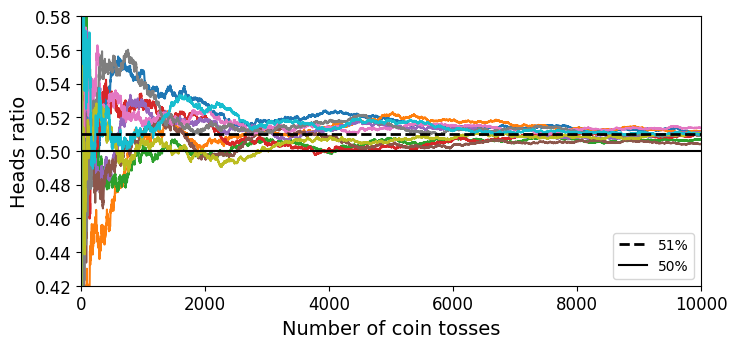

In [6]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
# save_fig("law_of_large_numbers_plot")
plt.show()

In the example above, the approach works because trials are independent from one another.

In fact, this independence is a fundamental requirement in order this approach to work best.

**Question**
Is this requirement always satisfied?

What does *independence* mean in our context?

 - We need to reduce the correlation between classifiers

---

**Voting classifier in sklearn**


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

First, you need to import the classifiers you want to include in you ensamble.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# instantiate the objects
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

# insert each estimator in the ensamble
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [ ]:
voting_clf.fit(X_train, y_train)

Let's confront the accuracy of each weak learner upon the test set, and compare these
results with the ones achieved by the ensemble learner.


In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

**Soft voting**

In [ ]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

If all the classifiers in the ensamble estimate class probabilities (the have the ``predict_proba()`` method) you can
adopt a soft-voting strategy. 

All you need to do is to replace ``voting=hard`` to ``voting=soft``.

**Try it yourself**
Note that the ``SVC`` classifier does not compute probabilities by default. But, if you set
the argument ``probability=True`` it will perform a cross validation test during training to estimate the class probabilities.

In [ ]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

## Bagging and Pasting

Obviously, with a voting approach, the only way to reduce the correlation between every weak learner errors,
is to select very different learners.


However, there is another approach, i.e., by using either bagging or pasting.

The common idea is to use a single algorithm -- instantiated multiple times -- and feed it with different 
subsets of data, drawn from the entire training set.

This strategy can be implemented in two ways:

1. Bagging - short for bootstrap aggregating, sampling __with replacement__
2. Pasting - sampling __without replacement__.

In other words, baggin may produce overlapping subsets, while pasting, conversely, produces non-overlapping samples of the training set.


![img/bagging.png](img/bagging.png)

Again, once every weak learner finishes its training, prediction 
are made by aggregating the outcome of every weak learner.

Most common approach is:

1. most frequent prediciton (like hard voting) for classification tasks
2. average for regression tasks

It should be noted that, weak learners have higher bias -- if compared with the case where they can have
access to the entire dataset -- however the aggregation is able to reduce this bias.

Generally speaking, the ensemble resulting by either bagging or pasting, has a bias that is similar
to the one of its weak learner, by the variance of the ensemble is significantly lower.


### Bagging and Pasting in Scikit-Learn

Scikit-Learn offers a simple API for both bagging and pasting with the ``BaggingClassifier`` class (or ``BaggingRegressor`` for regression). 

The following code trains an ensemble of 500 Decision Tree classifiers.

Each  tree is trained  upon 100 samples randomly selected from the training set, with 
replacement (otherwise, you can set ``bootstrap=False`` to 
use a pasting approach).

The ``n_jobs`` parameter tells Scikit-Learn the number of CPU cores to use for training and predictions (–1 tells Scikit-Learn to use all available cores):

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print("Ensamble accuracy: ",accuracy_score(y_test, y_pred))

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print("Single learner accuracy", accuracy_score(y_test, y_pred_tree))

Let's plot the decision boundaries of each classifier.


In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [ ]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
#save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

As you can see, 
the ensemble has smoother boundaries, as a consequence 
it can be far superior in terms of generalization.


The ensemble has a bias that is similar to the one of the weak learner, while
the variance is lower. This means that, with bagging, performance on the 
training set are roughly equivalent to the one of the weak learner, but it
behaves significantly better on the test set.

Therefore, bagging (sampling with replacement) has a 
higher bias and a lower variance compared to pasting.
In fact, in bagging the single predictors are less correlated
with each other.

Overall, bagging often results in better models, which explains why it is generally preferred over pasting.

### Out-of-Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. 

By default a ``BaggingClassifier`` samples ``m`` training instances with replacement (``bootstrap=True``). 

This means that there is a considerable amount of instances that are not sampled at all, thus they are
used to train any model. 

These instances are called out-of-bag (oob) instances.

Since a predictor never sees the oob instances during training, it can be evaluated against these instances, 
without the need for a separate validation set.

You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

In other words, the out-of-bag evaluation is __somehow__ similar to the cross validation. 

In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to request an automatic oob evaluation after training. The following code demonstrates this. The resulting evaluation score is available through the oob_score_ variable:


In [ ]:
bag_clf = BaggingClassifier(
                DecisionTreeClassifier(), 
                n_estimators=500,
                bootstrap=True, 
                n_jobs=-1,
                oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

The oob score roughly resembles the error on the test set

In [ ]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

### Random Patches and Random Subspaces

The ``BaggingClassifier`` class supports sampling the features as well. 


This behavior is controlled by two hyperparameters: ``max_features`` and ``bootstrap_features``. 

They are similar to  ``max_samples`` and ``bootstrap``, the only difference is that they apply to 
the feature selection process.

Thus, each predictor will be trained on a random subset of the input features.


The approach consisting of sampling both training instances and features is referred as **Random Patches**.

While the approach consisting of sampling only from the features space, while accounting for the entire
training set is called **Random Subspaces**.

Sampling features results in even more predictor diversity, therefore lower variance higher bias.

__Exercise__
Try a bagging classifier with random patches

In [ ]:
# your code here

## Random Forests

A Random Forest is an ensemble of Decision Trees.

Usually, training is performed with bagging (it bootstraps, sampling with replacement).

With ``max_samples`` you set the maximum number of points within each training set.

Similarly, there is a RandomForestRegressor class for regression tasks.

The following code trains a Random Forest classifier with 500 trees (each limited to maximum 16 nodes), using all available CPU cores:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

With a few exceptions, a  ``RandomForestClassifier`` has all the hyper-parameters of a ``DecisionTreeClassifier`` (to control how trees are grown),
plus all the hyperparameters of a 
``BaggingClassifier`` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees:
instead of searching for the very best feature when splitting a node
it searches for the best feature among a random subset of features. 

This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally producing a better model.
The following ``BaggingClassifier`` is roughly equivalent to the previous ``RandomForestClassifier``.

**Example**
Implement a random forest classifier using a ``BaggingClassifier``

In [ ]:
# implement it via the BaggingClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

In [ ]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

**Feature Importance**

Random Forest are also useful when one wants to estimate the importance of every feature 
in the dataset.

Importance is established by looking at the average impact of each feature in terms of impurity reduction.

More specifically, each spit of the data is associated with a feature and represented with a node.
The feature importance of a feature $f$ is the weighted by the average, where the weight is denoted 
by the number of training instances contained in a certain node, of the impurity reduction of every split 
$f$ is involved in.


Scikit-Learn computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. 

You can access the result using the ``feature_importances_`` variable. 

For example, the following code trains a ``RandomForestClassifier`` on the iris dataset and outputs each feature’s importance. 

It seems that the most important features are the petal length (44%) and width (42%), while sepal length and width are rather unimportant in comparison (11% and 2%, respectively).

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

In [ ]:
rnd_clf.feature_importances_

The following code trains 15 ``DecisionTreeClassifier``, each one of them is given with a different portion of the training set.

After every learning episode the decision boundaries are plotted.

In [ ]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

**Conclusions**
Random forest are very useful, not only for their prediction, but also for their ability 
to provide an understanding about the important features within a dataset.

In fact, one should always consider the adoption of a random forest classifier in order to extract the most important features
of a dataset.


---
## Boosting
Boosting is another ensemble method, that combines several weak learners.

It is based on an iterative and incremental learning strategy. 
At each iteration, a weak learner is trained trying to correct the errors
made by the previous learner.

There are many boosting methods available, but by far the most popular are AdaBoost (short for Adaptive Boosting) and Gradient Boosting. Let’s start with AdaBoost.

### AdaBoost
One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted.

This this approach, each leaner focuses on the errors on its  predecessor.

This is the method adopted in ``AdaBoost``

With ``AdaBoost``, first a base classifier is trained. 
Then, accordingly to the predictions of this classifier, each data point is associated with a weight, whose
value is proportional to the error made by the algorithm.

In the next iteration, a new classifier is trained upon the weighted dataset and then the weights are updated
for the following iteration.

Here is a schema of this approach.

![img/adaboost.png](img/adaboost.png)


Once all predictors are trained, prediction are carried with a soft-voting mechanism,
where each learner has a weight proportional to its accuracy.


**Question**
There is a major drawback with this technique. Any idea?

*Hint: parallelism/scalability*

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

In [ ]:
plot_decision_boundary(ada_clf, X, y)


The decision boundaries of five consecutive predictors on the moons dataset (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel). 

- The first classifier gets many instances wrong, so their weights get boosted. 

- The second classifier therefore does a better job on these instances, and so on.

The plot on the right represents the same sequence of predictors except that the learning rate is halved (i.e., the misclassified instance weights are boosted half as much at every iteration). 



In [ ]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

# save_fig("boosting_plot")
plt.show()

Here is the list of the internal variables of AdaBoost.

In [ ]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

**Let's take a closer look**
At the beginning, each data point in the training set $\mathcal{D}$ has the same weight,
for instance $w^{(i)} = \frac{1}{m}$ for 
every $x^{(i)} \in \mathcal{D}$ (m is the size of the training set).

After the first training episode, a weighted error is computed for each data point in the training set. 

The weighted error rate of the j-th predictor is is given by:

$$
r_j = \frac{\sum_{\forall i  \text{ s.t. } \hat{y^{(i)}} \neq y^{(i)} }^{m} w^{(i)}}{\sum_{i=1}^m w^{(i)}}
$$

This score is then used to establish the weight of the classifiers, according to the
following function:

$$
\alpha_j = \eta \log \frac{1-r_j}{r_j}
$$

where $\eta$ is the learning rate (1 by default).

Clearly, the weight is proportional to the accuracy of a classifier.


Then, at end of the next training episode, the weights are updated 
according to the folling equation:
$$
w^{(i)} = \left\{ \begin{array}{ll}
                    w^{(i)} & \text{if } \hat{y^{(i)}} = y^{(i)} \\
                    w^{(i)}  e^{\alpha_j} & \text{otherwise}
                  \end{array}\right.
$$

At the beginning of each training episode, weights are normalized, i.e., they are divided by $\sum_{i=1}^{m} w^{(i)}$.

This process is repeated iteratively until either the predefined number of predictors is reached or the perfect predictor is found.

Finally any prediction is made according to the following rule:

$$
\hat{y}(x) = \text{arg}\!\max_{k} \sum_{j=1\\\hat{y_j}(x) = k}^{N} \alpha_j
$$

It is the class that received most votes (weighted by the $\alpha$ score of each predictor).

Where $N$ is the number of predictors.

# Gradient Boosting

Another very popular Boosting algorithm is Gradient Boosting. 

Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one is built on top of its predecessor. 

However, instead of assigning weights to data points, at every iteration 
GB tries to fit the errors/residual of the previous training episode.

Let’s go through a simple regression example using Decision Trees as the base predictors.

This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT).
First, let’s fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic training set):

In [ ]:
from sklearn.tree import DecisionTreeRegressor
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
np.random.seed(42)

# train the first predictor
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

# compute the residual and train the second predictor
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

# compute the residual and train the third predictor
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

Now we have an ensemble containing three trees.
It can make predictions on a new instance simply by adding up the predictions of all the trees.

In [ ]:
# prediction
X_new = np.array([[0.8]])
y_new = 3*X_new**2 + 0.05 * np.random.randn(1)
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

The following figures represent the predictions of these trees in the left column,
vs the ensemble’s predictions in the right column. 

In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. 

In the second row, a new tree is trained on the residual errors of the first tree. 
On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. 


Similarly, in the third row another tree is trained on the residual errors of the second tree.


You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.



In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

# save_fig("gradient_boosting_plot")
plt.show()

Of course sklearn provides a class for this kind of ensemble.

One important parameter is the  ``learning_rate``.
If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set,
but the predictions will usually generalize better. 




In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

Figure shows two GBRT ensembles trained with a low learning rate: the one on the left does not have enough trees to fit the training set, while the one on the right has too many trees and overfits the training set.

In [ ]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

# save_fig("gbrt_learning_rate_plot")
plt.show()

## Gradient Boosting with Early stopping

In order to find the optimal number of trees, you can use a technique called _early stopping_.

A simple way to implement it, is via the  ``staged_predict()`` method, which returns
an iterator upon all the predictions made by the at each stage of training.


The following code trains a GBRT ensemble with 120 trees, 
then measures the validation error at each stage of training 
to find the optimal number of trees.
Finally it trains another 
GBRT ensemble using the optimal number of trees:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# use staged_predict for getting a sequence of predictions
# !!!!!!!!! THE EVALUATION MUST BE DONE OUT-SAMPLE (ON THE VALIDATION SET) !!!!!!!!!!!
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]

# get the number of tree corresponding to the minimum error
bst_n_estimators = np.argmin(errors)

# re-train the regressor
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

In [ ]:
min_error = np.min(errors)

In [ ]:
plt.figure(figsize=(11, 4))

plt.subplot(131)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(132)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

# save_fig("early_stopping_gbrt_plot")
plt.show()

Another way to implement an early stopping technique is
to specify   ``warm_start=True``.

The following code stop training when the validation error does not improve for five iterationin a row.

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [ ]:
print(gbrt.n_estimators)

In [ ]:
print("Minimum validation MSE:", min_val_error)

GradientBoosting provide also an additional option, called ``subsample``. 

For instance, when ``subsample=.25``, it means that each tree in the ensamble is trained against
the  25% of the entire training set. 

Of course, in this way you are introducing more variance.

This technique is often referred as **Stochastic Gradient Boosting**.

It is generally faster than the previous solutions.



### Using XGBoost
It is an optimized implementation of gradient boosting.


In [ ]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [ ]:
if xgboost is not None:  
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) 
    print("Validation MSE:", val_error)        

In [ ]:
if xgboost is not None: 
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) 
    print("Validation MSE:", val_error)            

In [ ]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

In [ ]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

It does not guarantee a boost in performance in terms of effectiveness, but it does provide a boost in performance in terms of efficiency.

## Stacking Ensemble
Stacking stands for Stacked generalization.

It is based on a simple idea: instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, 
why don’t we train a model to perform this aggregation? 

Figure shows such an ensemble performing a regression task on a new instance. Each of the bottom three predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor (called a blender, or a meta learner) takes these predictions as inputs and makes the final prediction (3.0).

![img/stacking1.png](img/stacking1.png)


To train the *blender*, a common approach is to use a hold-out set. 

---

Let’s see how it works. First, the training set is split in two subsets. 

> **The first subset**. 
    The first subset is used to train the predictors in the first layer.
    Next, the first layer predictors are used to make predictions on the second (held-out) set. This
    ensures that the predictions are “clean,” since the predictors never saw these instances during training.

![img/stacking2.png](img/stacking2.png)

> **The second subset**. It is created starting from the predictions made by the estimators trained wrt the first subset of training samples.
 Now for each instance in the hold-out set there are three predicted values. We can create     a new training set using these predicted values as input features (which makes this new training set 
 three-dimensional), and keeping the target values. The blender is trained on this new training 
 set, so it learns to predict the target value given the first layer’s predictions.


![img/stacking3.png](img/stacking3.png)


It is actually possible to train several different blenders this way (e.g., one using Linear Regression, another using Random Forest Regression, and so on): we get a whole layer of blenders. The trick is to split the training set into three subsets: the first one is used to train the first layer, the second one is used to create the training set used to train the second layer (using predictions made by the predictors of the first layer), and the third one is used to create the training set to train the third layer (using predictions made by the predictors of the second layer). Once this is done, we can make a prediction for a new instance by going through each layer sequentially, as shown in Figure.


Unfortunately, Scikit-Learn does not support stacking directly, but it is not too hard to roll out your own implementation.
